# IMPORTING LIBRARIES AND DEFINING DIRECTORY

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python import train
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os,sys
from pathlib import Path

Verifying that the definition of the current directory was well made:

(768, 1024)


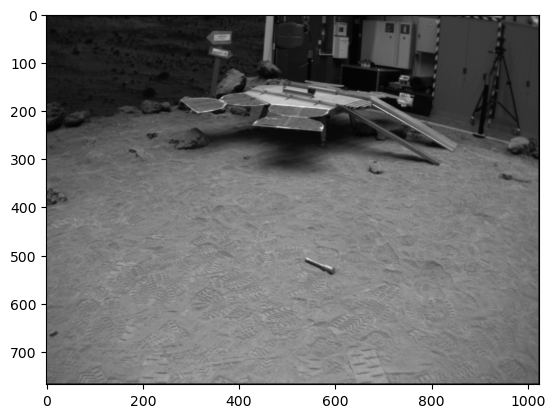

In [25]:
im = plt.imread(Path("./train_images/real/train/Treal_N1.png"))
print(im.shape)
plt.imshow(im, cmap="gray")

We can already conclude that the images have 768x1024 pixels

# IMPORTING THE IMAGES FROM THE DIRECTORY

In [26]:
import glob

def importImagesFromDirectory(directory):
    df_images = pd.DataFrame()
    
    for im_path in glob.glob(str(directory) + "/*.png"):
        im = plt.imread(im_path)

        dic_aux = {'Image':[im], 'ImageName': im_path[26:]}
        df_aux = pd.DataFrame(dic_aux)
        df_images = pd.concat([df_images, df_aux], ignore_index=True)
    
    df_images.set_index('ImageName', inplace = True)

    return df_images


df_images = importImagesFromDirectory("./train_images/real/train")
#df_images.head()

^^ As we can see, the images are imported in alphabetical order, so we changed the names to from Treal_N1, Treal_N2,... to Tral_N01, Treal_N02,... in order to have the desired order

In [27]:
df_images.head(2)

,Image
ImageName,
Treal_N33.png,"[[0.12156863, 0.12156863, 0.12156863, 0.121568..."
Treal_N3.png,"[[0.078431375, 0.078431375, 0.08235294, 0.0823..."


In [28]:
type(df_images['Image'][0])  #the images are numpy arrays

numpy.ndarray

LETS SEE IF THE IMAGES ARE BEING IMPORTED AS DESIRED

In [29]:
currentIndex = 0

0
Treal_N33.png


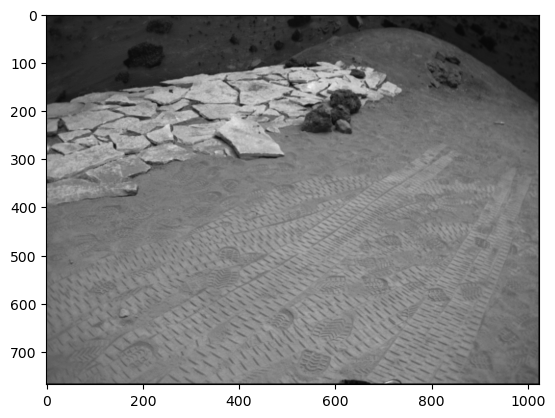

In [30]:
plt.imshow(df_images.iloc[currentIndex,0], cmap="gray")
print(currentIndex)
print(df_images.index[currentIndex]) #df_images.index is a series
currentIndex = (currentIndex + 1) % 49

Confirmed that the images were imported in the right order

# IMPORTING THE TARGET DATA FROM THE CSV FILE



In [31]:
data = pd.read_csv(Path("./train_images/real/real_scene.csv"))
data.head()

,image,xmin,ymin,xmax,ymax,label
0,Treal_N11.png,418.660017,40.017738,461.220283,53.640798,sample
1,Treal_N1.png,529.316708,497.241685,604.222776,545.773836,sample
2,Treal_N12.png,476.541978,421.463415,542.935993,464.035477,sample
3,Treal_N13.png,854.477140,292.895787,892.781380,323.547672,sample
4,Treal_N10.png,413.552785,182.208426,458.666667,206.900222,sample


In [32]:
if data.index.name != 'image': #this allows to run this cell multiple times without givin an error ('name' is the name of the index)
    data.set_index('image', inplace=True)
data.head(2)
#data.reset_index(level = 'name', inplace = True)

,xmin,ymin,xmax,ymax,label
image,,,,,
Treal_N11.png,418.660017,40.017738,461.220283,53.640798,sample
Treal_N1.png,529.316708,497.241685,604.222776,545.773836,sample


In [33]:
data = data.loc[:,['xmin','xmax','ymin','ymax']] #label wont be necessary in this case
data.head(2)

,xmin,xmax,ymin,ymax
image,,,,
Treal_N11.png,418.660017,461.220283,40.017738,53.640798
Treal_N1.png,529.316708,604.222776,497.241685,545.773836


ONCE WE'VE SEEN THE PIPELINE WE WANT, WE CAN CREATE A FUNCTION THAT RESUMES IT ALL

In [34]:
def importingExcelData(path):
    data = pd.read_csv(path)
    data.set_index('image', inplace=True)
    data = data.loc[:,['xmin','xmax','ymin','ymax']]
    return data

# CREATING THE FINAL DATAFRAME

In [35]:
df = pd.merge(df_images, data, left_on='ImageName', right_on='image', how='left')
df.tail(5)

,Image,xmin,xmax,ymin,ymax
44,"[[0.101960786, 0.105882354, 0.105882354, 0.101...",531.870324,673.170407,275.866962,334.616408
45,"[[0.12156863, 0.12156863, 0.12941177, 0.129411...",671.467997,749.778886,417.206208,441.046563
46,"[[0.043137256, 0.043137256, 0.043137256, 0.043...",572.728180,660.402328,587.494457,663.272727
47,"[[0.16862746, 0.16862746, 0.1764706, 0.1764706...",588.049875,713.177057,409.543237,496.390244
48,"[[0.101960786, 0.101960786, 0.09411765, 0.0941...",589.752286,681.682461,670.084257,755.228381


# VERIFYING THAT THE LABELS ARE CORRECT

In [36]:
import math
def objectRectangleRounding(xmin, xmax, ymin, ymax):
    xmin = math.floor(xmin)
    xmax = math.ceil(xmax)
    ymin = math.floor(ymin)
    ymax = math.ceil(ymax)
    return xmin, xmax, ymin, ymax

row = df.iloc[0,:]
objectRectangleRounding(row[1], row[2], row[3], row[4])

(922, 957, 213, 235)

In [37]:
def objectRectangleDrawing(dataFrameRow):
    image = np.copy(dataFrameRow[0])
    xmin, xmax, ymin, ymax = objectRectangleRounding(dataFrameRow[1], dataFrameRow[2], dataFrameRow[3], dataFrameRow[4])

    for index, row in enumerate(image):
        if index == ymin or index == ymax:
            row[xmin:xmax] = np.ones((1, xmax-xmin))
        if ymin < index and index < ymax:
            row[xmin] = 1
            row[xmax] = 1
    return image

In [38]:
data = importingExcelData(Path("./train_images/real/real_scene.csv"))
df = pd.merge(df_images, data, left_on='ImageName', right_on='image', how='left')

In [39]:
currentIndex = 0

0


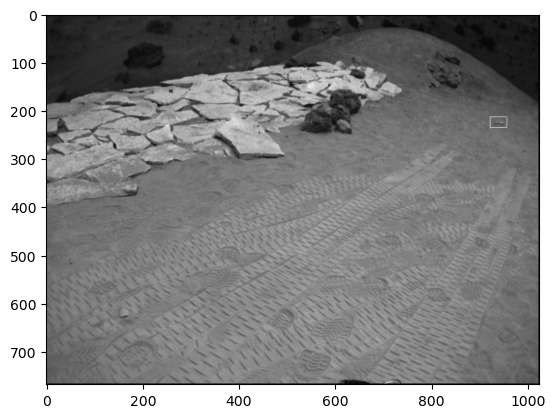

In [40]:
data = importingExcelData(Path("./train_images/real/real_scene.csv"))
df = pd.merge(df_images, data, left_on='ImageName', right_on='image', how='left')
plt.imshow(objectRectangleDrawing(df.iloc[currentIndex,:]), cmap = "gray")
print(currentIndex)

currentIndex = (1)%df.shape[0]


Confirmou-se que todas as fotos têm o retângulo adequado

No entanto, alguns retângulos estão folgados, podem ser ajustados no futuro para tentar perceber se melhora os resultados

In [41]:
def divideImage(row, ydim, xdim):
    image = row[0]
    xmin = row[1]
    xmax = row[2]
    ymin = row[3]
    ymax = row[4]
    imageYDimension = image.shape[0]
    imageXDimension = image.shape[1]
    
    # TODO: add a little buffer so extreme case where only a few pixels of the tube are in the picture are not considered

    xLowerLimit = 0
    yLowerLimit = 0

    df = pd.DataFrame()

    while yLowerLimit < imageYDimension:
        if yLowerLimit + ydim > imageYDimension: #to handle if the last line of squares goes out of bounds
            yLowerLimit = imageYDimension - ydim

        while xLowerLimit < imageXDimension:
            #Getting the subImage
            if xLowerLimit + xdim > imageXDimension: #to handle if the last line of squares goes out of bounds
                xLowerLimit = imageXDimension - xdim
            
            im = image[ yLowerLimit : yLowerLimit + ydim  ,  xLowerLimit : xLowerLimit + xdim]
            #--------
            #Checking if the subImage is inside the square of the object
            #In fact it is easier to check if the subImage is outside the square
            if ((xLowerLimit + xdim < xmin) or (xLowerLimit > xmax) or (yLowerLimit + ydim < ymin) or (yLowerLimit > ymax)):
                #reason = [(xLowerLimit + xdim < xmin) , (xLowerLimit > xmax) , (yLowerLimit + ydim < ymin) , (yLowerLimit > ymax)]  #debug
                label = 0
            else:
                #reason = [(xLowerLimit + xdim < xmin) , (xLowerLimit > xmax) , (yLowerLimit + ydim < ymin) , (yLowerLimit > ymax)]  #debug
                label = 1
            #-------
            
            dic_aux = {'subImages':[im], 'label':label} #, 'reason':[reason]}
            df_aux = pd.DataFrame(dic_aux)
            df = pd.concat([df, df_aux], ignore_index=True)
            
            xLowerLimit += xdim


        xLowerLimit = 0
        yLowerLimit += ydim
    
    return df

In [42]:
row = df.iloc[0,:]
df_subImages = divideImage(row, 96, 128)
print(df_subImages.shape)

(64, 2)


In [43]:
df_subImages = pd.DataFrame()
for index in range(df.shape[0]):
    df_subImages = pd.concat([df_subImages, divideImage(df.iloc[index,:], 96, 128)], ignore_index=True)
df_subImages.shape

(3136, 2)

In [44]:
df_subImages['label'].value_counts()

0    3028
1     108
Name: label, dtype: int64

In [45]:
df_subImages.head(5)

,subImages,label
0,"[[0.12156863, 0.12156863, 0.12156863, 0.121568...",0
1,"[[0.15686275, 0.15686275, 0.15686275, 0.156862...",0
2,"[[0.1882353, 0.1882353, 0.18039216, 0.18431373...",0
3,"[[0.18039216, 0.1764706, 0.1882353, 0.19607843...",0
4,"[[0.14901961, 0.14901961, 0.13333334, 0.113725...",0


In [46]:
df_subImages.to_pickle('subImages')